# Uso de Ecobicis vs. Temperatura Mensual en CABA

In [1]:
import numpy as np
import pandas as pd
from scripts.data import analysis_temperature
from scripts.correlation import correlation_analysis

In [2]:
recorridos_data = pd.read_csv("data/recorridos-realizados-todo.csv", low_memory=False)
recorridos_data.head()

,ORIGEN,FECHA,GENERO,MES_NUM,ANIO,MES
0,ONCE,2014-01-02 08:03:44.437,NaN,1,2014,Enero
1,SUIPACHA,2014-01-02 08:33:59.873,NaN,1,2014,Enero
2,CONGRESO,2014-01-02 08:43:09.263,NaN,1,2014,Enero
3,VIRREY CEVALLOS,2014-01-02 08:43:37.700,NaN,1,2014,Enero
4,RETIRO,2014-01-02 08:47:58.217,NaN,1,2014,Enero


In [3]:
temp_data = analysis_temperature().reset_index()
temp_data.head()

,Year,Month,TempMinAbs,TempMaxAbs,TempMinMean,TempMaxMean,TempMean
0,1991,Enero,NaN,NaN,19.8,28.4,24.0
1,1992,Enero,NaN,NaN,19.8,28.5,23.9
2,1993,Enero,NaN,NaN,21.2,30.7,25.7
3,1994,Enero,NaN,NaN,18.7,28.4,23.5
4,1995,Enero,NaN,NaN,19.5,29.4,24.3


In [4]:
def prep_analysis_data(recorridos):
    def imputed_recorridos(data):
        months = [
            "Enero",
            "Febrero",
            "Marzo",
            "Abril",
            "Mayo",
            "Junio",
            "Julio",
            "Agosto",
            "Septiembre",
            "Octubre",
            "Noviembre",
            "Diciembre",
        ]
        month_nums = range(1, 13)
        years = range(np.min(data["ANIO"]), 2025)
        mean_recorridos = data["RECORRIDOS"].mean()

        expected_groups = [
            (y, m)
            for y in years
            for m in month_nums
            if y != 2024 or y == 2024 and m < 5
        ]

        missing_groups = []
        for year, month_num in expected_groups:
            in_data = data[data["ANIO"] == year][["MES_NUM"]].values
            if month_num not in in_data:
                missing_groups.append((year, month_num))

        # print("Missing groups:", missing_groups)

        def prev_group(year, month_num):
            if month_num == 1:
                return (year - 1, 12)
            return (year, month_num - 1)

        def next_group(year, month_num):
            if month_num == 12:
                return (year + 1, 1)
            return (year, month_num + 1)

        def find_prev_group(year, month_num):
            prev = prev_group(year, month_num)
            if prev in missing_groups:
                return find_prev_group(*prev)
            return prev

        def find_next_group(year, month_num):
            next = next_group(year, month_num)
            if next in missing_groups:
                return find_next_group(*next)
            return next

        def lookup_recorridos(year, month_num):
            recorridos = data[(data["ANIO"] == year) & (data["MES_NUM"] == month_num)][
                "RECORRIDOS"
            ].values

            if len(recorridos) == 0:
                return mean_recorridos
            return recorridos[0]

        def group_distance(group1, group2):
            return (group2[0] - group1[0]) * 12 + group2[1] - group1[1]

        def interpolate_recorridos(group, prev, next):
            prev_recorridos = lookup_recorridos(*prev)
            next_recorridos = lookup_recorridos(*next)
            distance = group_distance(prev, next)

            return (
                prev_recorridos
                + group_distance(prev, group)
                * (next_recorridos - prev_recorridos)
                / distance
            )

        missing_data = {"ANIO": [], "MES_NUM": [], "MES": [], "RECORRIDOS": []}
        for group in missing_groups:
            year, month_num = group
            prev = find_prev_group(*group)
            next = find_next_group(*group)

            missing_data["ANIO"].append(year)
            missing_data["MES_NUM"].append(month_num)
            missing_data["MES"].append(months[month_num - 1])

            imputed_recorridos = round(interpolate_recorridos(group, prev, next))
            missing_data["RECORRIDOS"].append(imputed_recorridos)

        return pd.DataFrame(missing_data)

    missing_df = imputed_recorridos(recorridos)

    imputed_data = pd.concat([recorridos, missing_df], ignore_index=True).sort_values(
        by=["ANIO", "MES_NUM"]
    )

    analysis_data = pd.DataFrame(
        imputed_data.merge(
            temp_data, left_on=["ANIO", "MES"], right_on=["Year", "Month"], how="left"
        )[["ANIO", "MES_NUM", "MES", "RECORRIDOS", "TempMean"]]
    ).rename(columns={"TempMean": "TEMP"})

    return pd.DataFrame(analysis_data)

In [41]:
analysis = {}


def group_data(data):
    return pd.DataFrame(
        data.groupby(["ANIO", "MES_NUM", "MES"], as_index=False).size()
    ).rename(columns={"size": "RECORRIDOS"})


target_data = group_data(recorridos_data)
analysis_data = prep_analysis_data(target_data)
analysis["ALL"] = analysis_data[analysis_data["ANIO"] < 2024]

target_data = group_data(
    recorridos_data[
        (recorridos_data["GENERO"] == "MASCULINO") & (recorridos_data["ANIO"] > 2014)
    ]
)
analysis_data = prep_analysis_data(target_data)
analysis["MASCULINO"] = analysis_data[analysis_data["ANIO"] < 2024]

target_data = group_data(
    recorridos_data[
        (recorridos_data["GENERO"] == "FEMENINO") & (recorridos_data["ANIO"] > 2014)
    ]
)
analysis_data = prep_analysis_data(target_data)
analysis["FEMENINO"] = analysis_data[analysis_data["ANIO"] < 2024]


analysis["ALL < 2019"] = analysis["ALL"][analysis["ALL"]["ANIO"] < 2019]
analysis["MASCULINO < 2019"] = analysis["MASCULINO"][
    analysis["MASCULINO"]["ANIO"] < 2019
]
analysis["FEMENINO < 2019"] = analysis["FEMENINO"][analysis["FEMENINO"]["ANIO"] < 2019]

analysis["ALL >= 2020"] = pd.DataFrame(
    analysis["ALL"][analysis["ALL"]["ANIO"] >= 2020]
).reset_index(drop=True)

analysis["MASCULINO >= 2020"] = pd.DataFrame(
    analysis["MASCULINO"][analysis["MASCULINO"]["ANIO"] >= 2020]
).reset_index(drop=True)

analysis["FEMENINO >= 2020"] = pd.DataFrame(
    analysis["FEMENINO"][analysis["FEMENINO"]["ANIO"] >= 2020]
).reset_index(drop=True)

for name, df in analysis.items():
    print("Name:", name, ", Data Count", df.size)

Name: ALL , Data Count 600
Name: MASCULINO , Data Count 540
Name: FEMENINO , Data Count 540
Name: ALL < 2019 , Data Count 300
Name: MASCULINO < 2019 , Data Count 240
Name: FEMENINO < 2019 , Data Count 240
Name: ALL >= 2020 , Data Count 240
Name: MASCULINO >= 2020 , Data Count 240
Name: FEMENINO >= 2020 , Data Count 240
Name: CONGRESO >= 2020 , Data Count 240


In [18]:
def run_analysis(data, title):
    xticks_data = data[data["MES_NUM"] == 1]
    xticklabels = pd.Series(xticks_data["ANIO"])
    xticks = pd.Series(xticks_data.index.get_level_values(0))

    correlation_analysis(
        pd.Series(data["RECORRIDOS"]),
        pd.Series(data["TEMP"]),
        title="Uso de Ecobicis vs. Temperatura Mensual en CABA",
        ts_xlabel="Año",
        ts_ylabel1="Uso de Ecobicis / mes",
        ts_ylabel2="Temperatura Promedio Mensual (°C)",
        ts_xticks=xticks,
        ts_xticklabels=xticklabels,
        corr_xticks=xticks,
        corr_xticklabels=None,
        ts_plot_opts1={"label": "Ecobicis"},
        ts_plot_opts2={"label": "Temperatura", "color": "red", "linestyle": "--"},
        corr_plot_opts={},
        suptitle=title,
    )

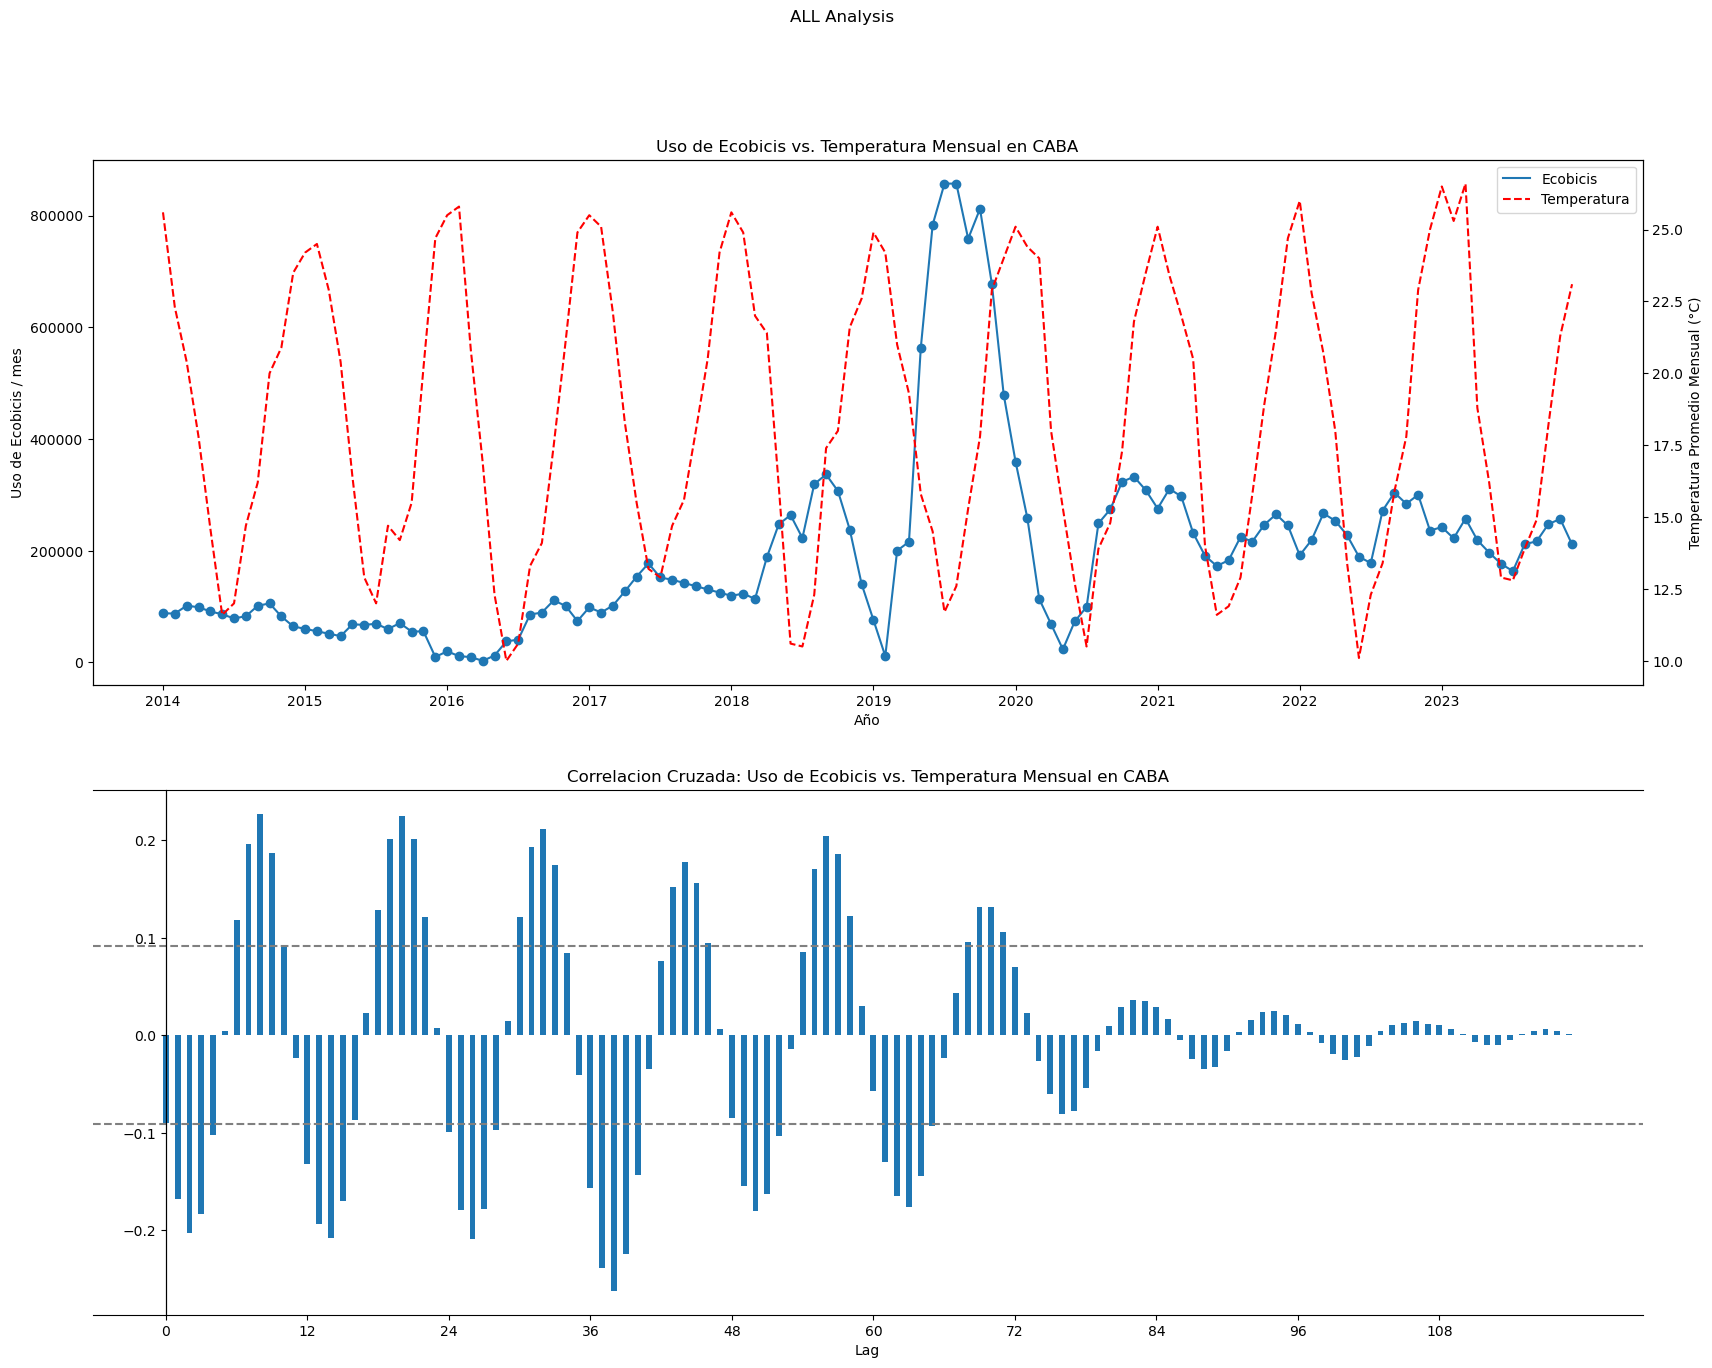

Coeficiente de Correlacion de Pearson: -0.09000482694433397


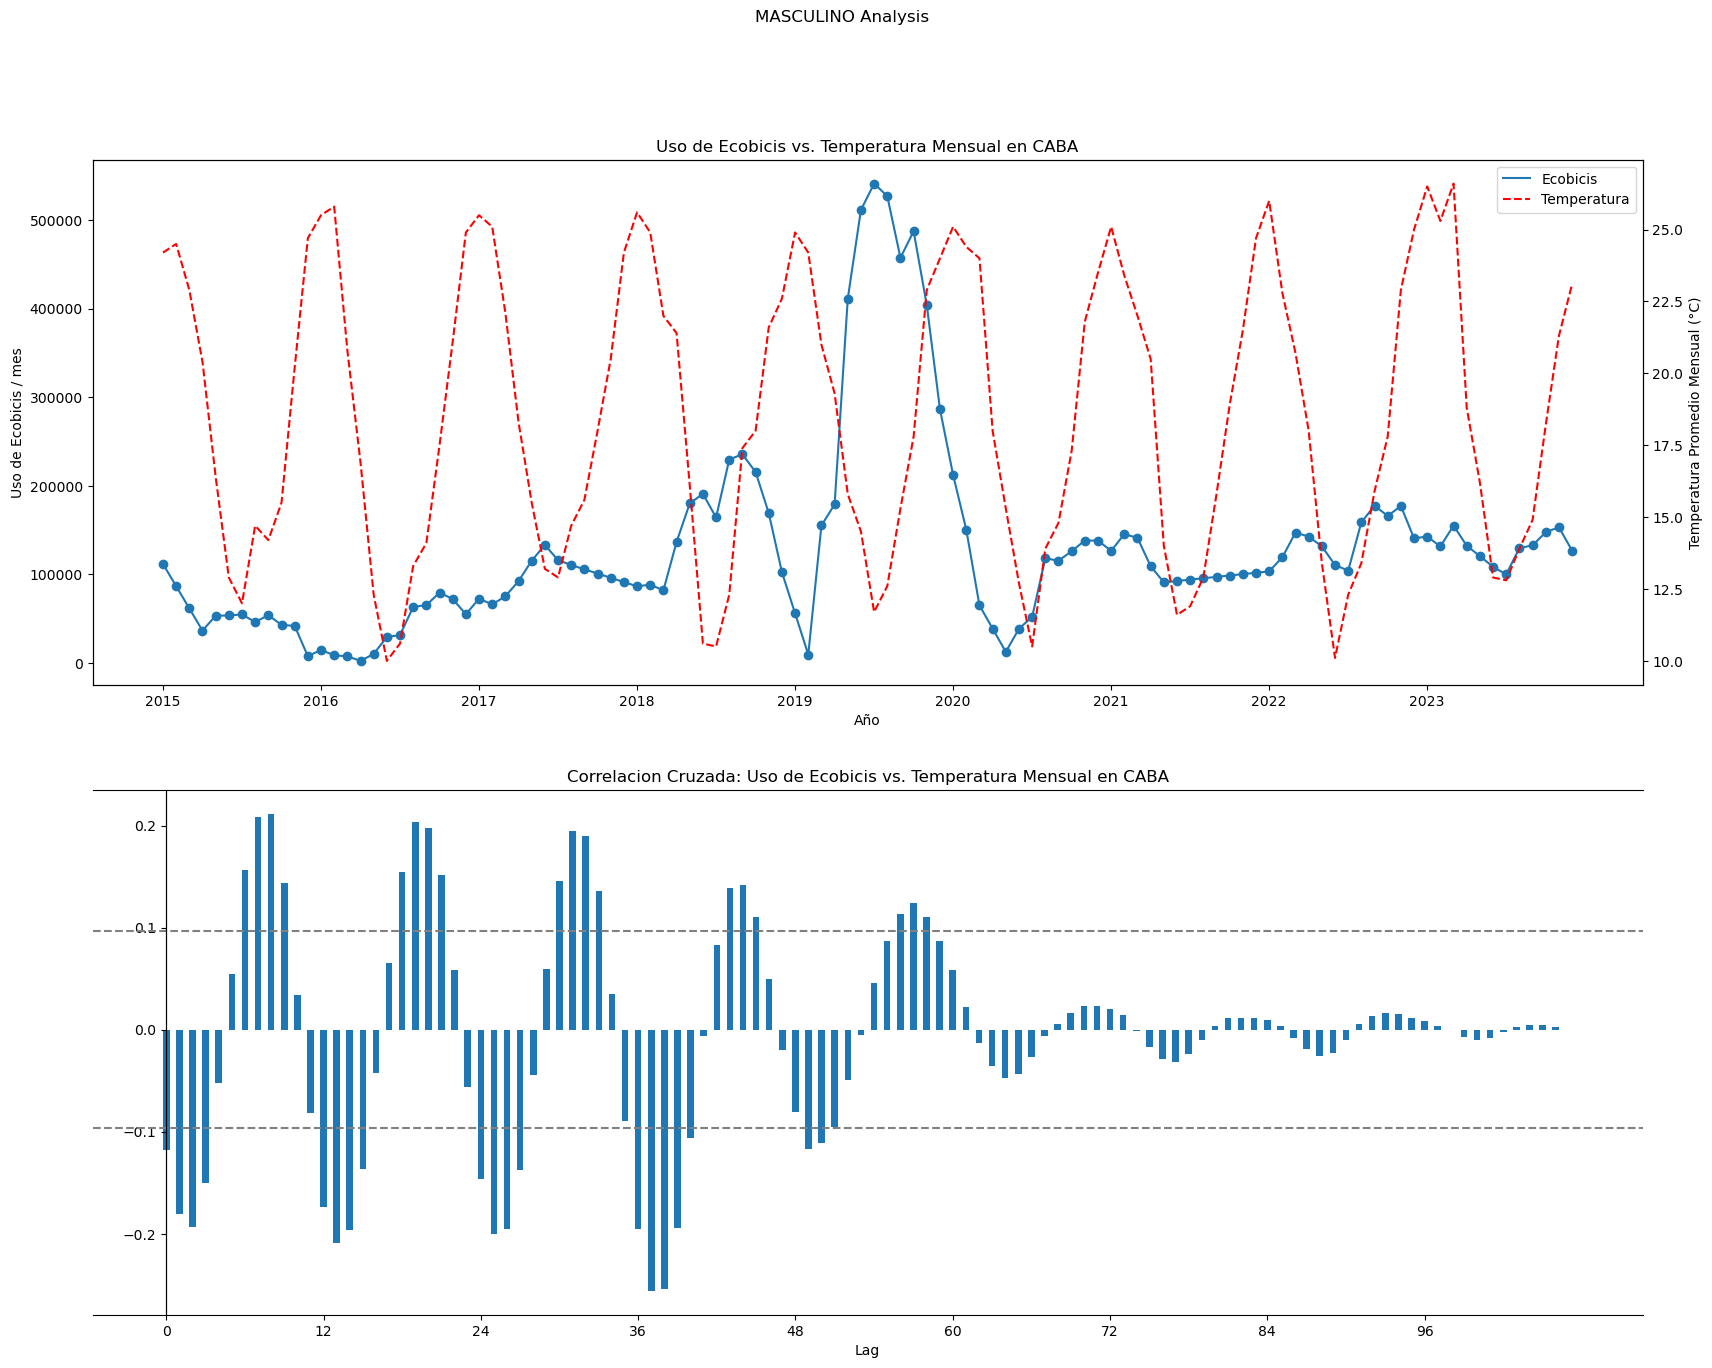

Coeficiente de Correlacion de Pearson: -0.11813967101748904


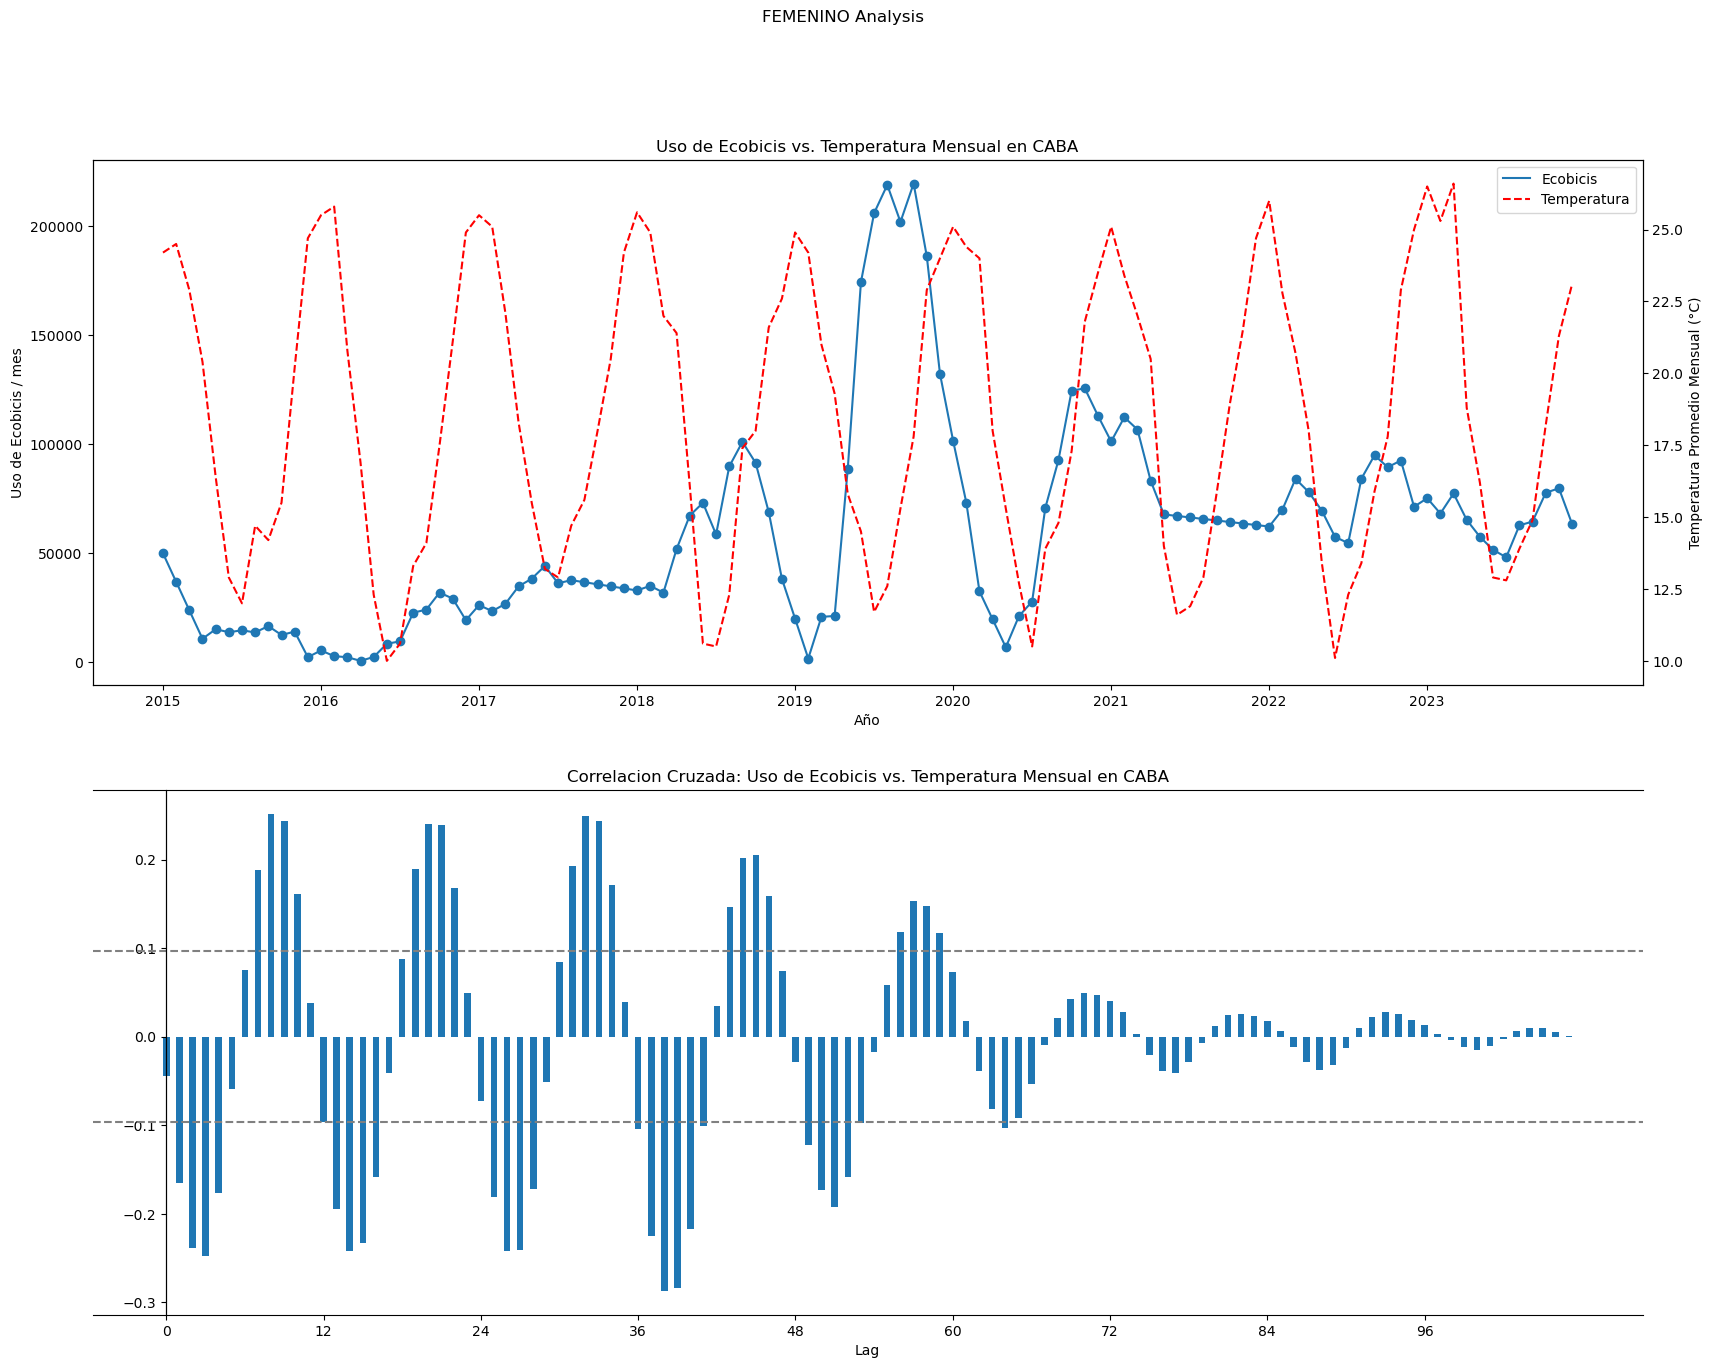

Coeficiente de Correlacion de Pearson: -0.044024890364591236


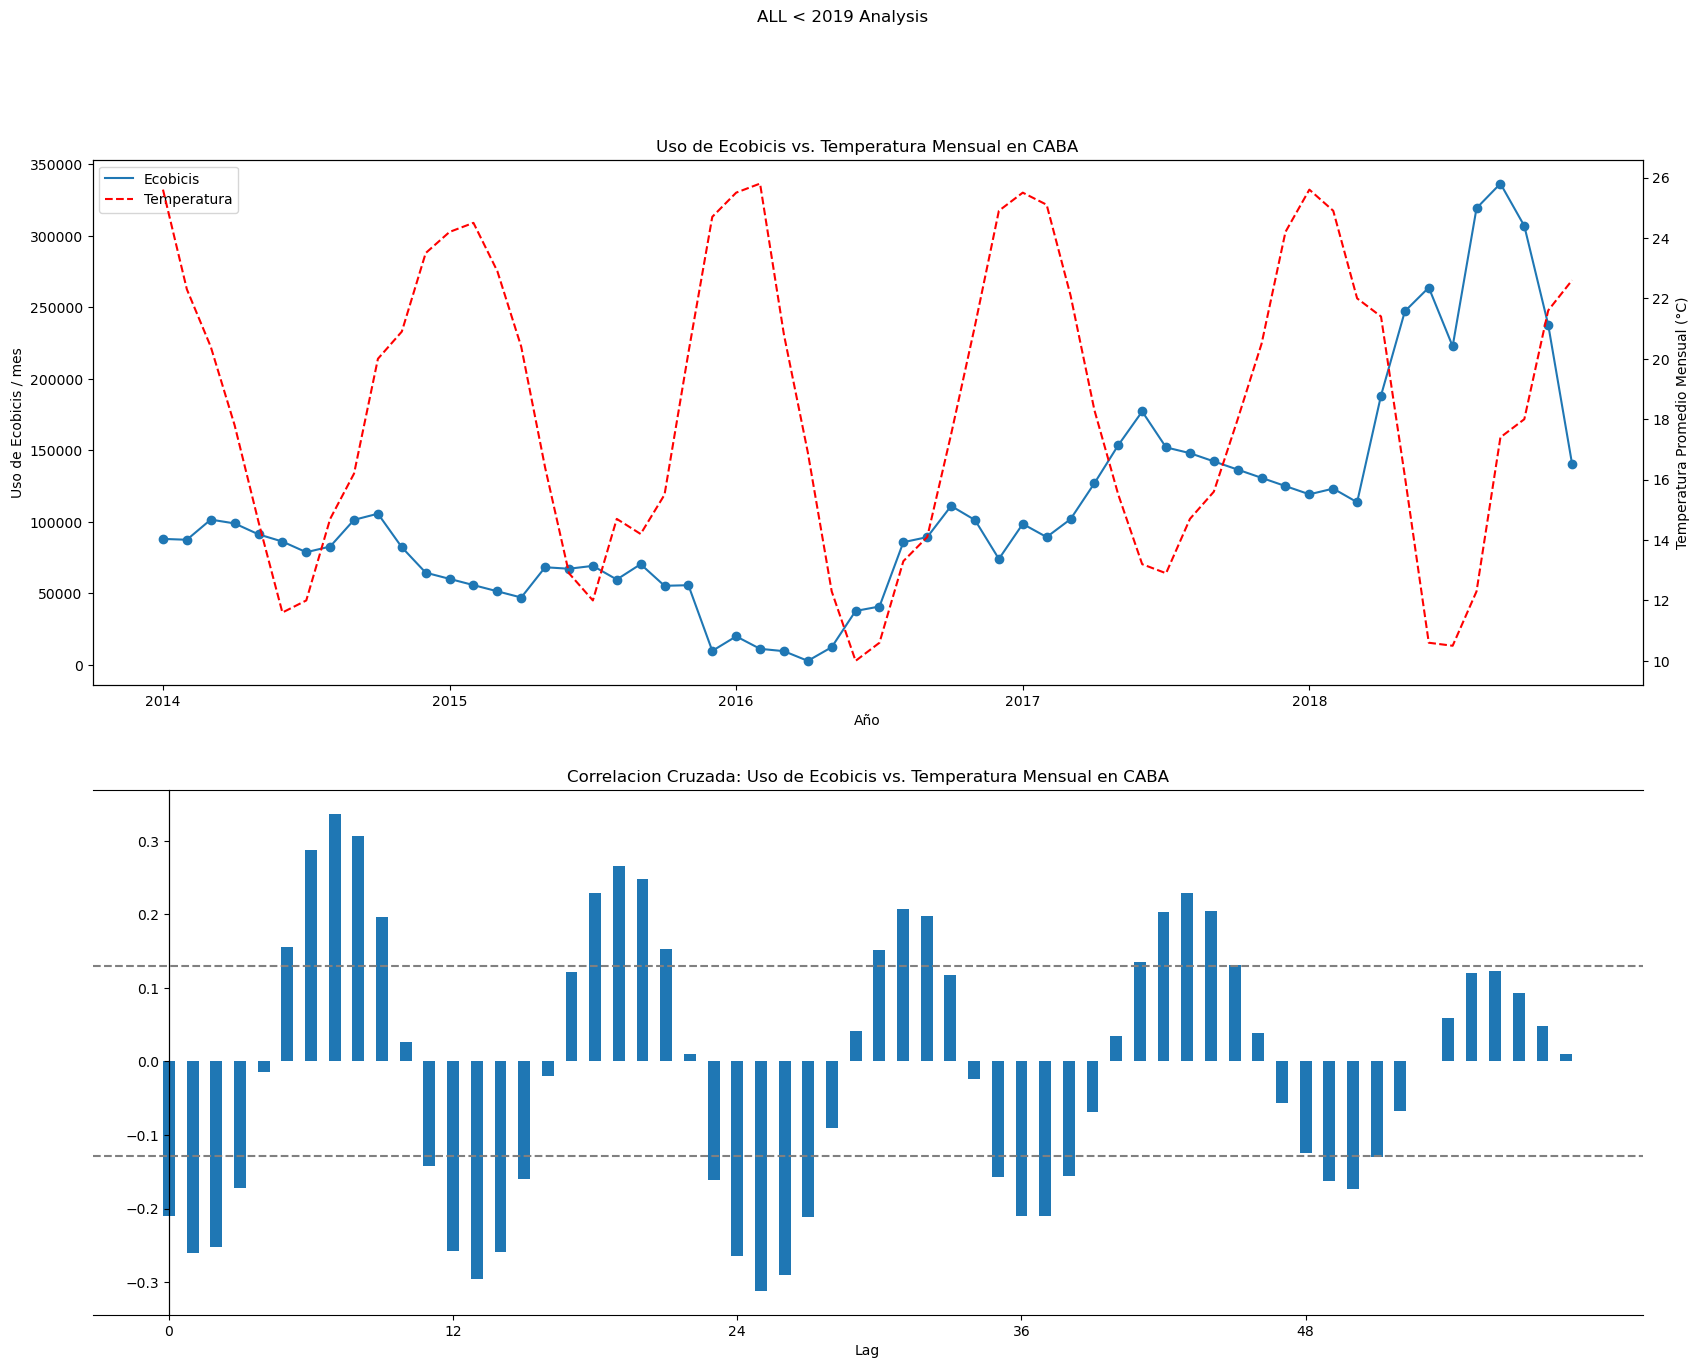

Coeficiente de Correlacion de Pearson: -0.21017203867638287


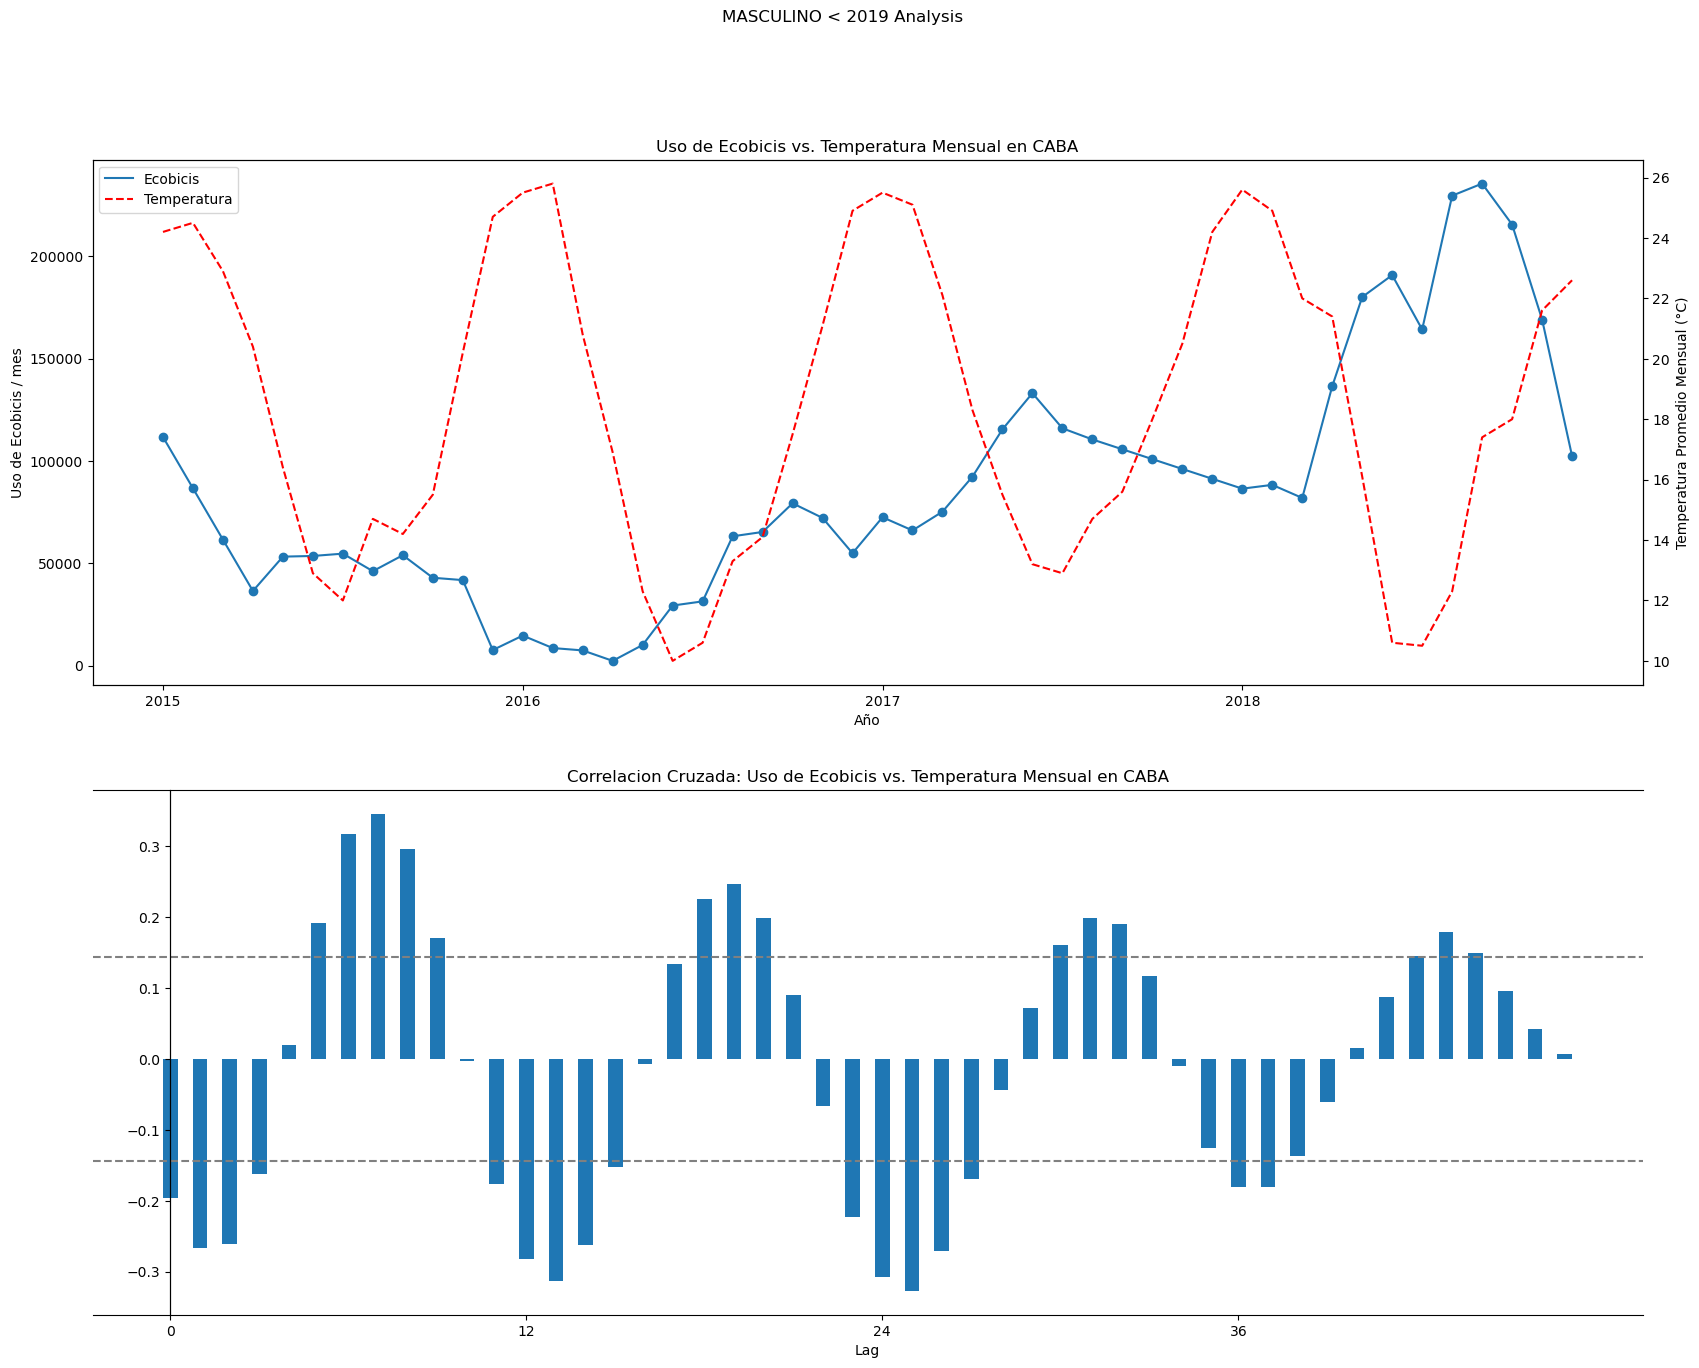

Coeficiente de Correlacion de Pearson: -0.196581598392226


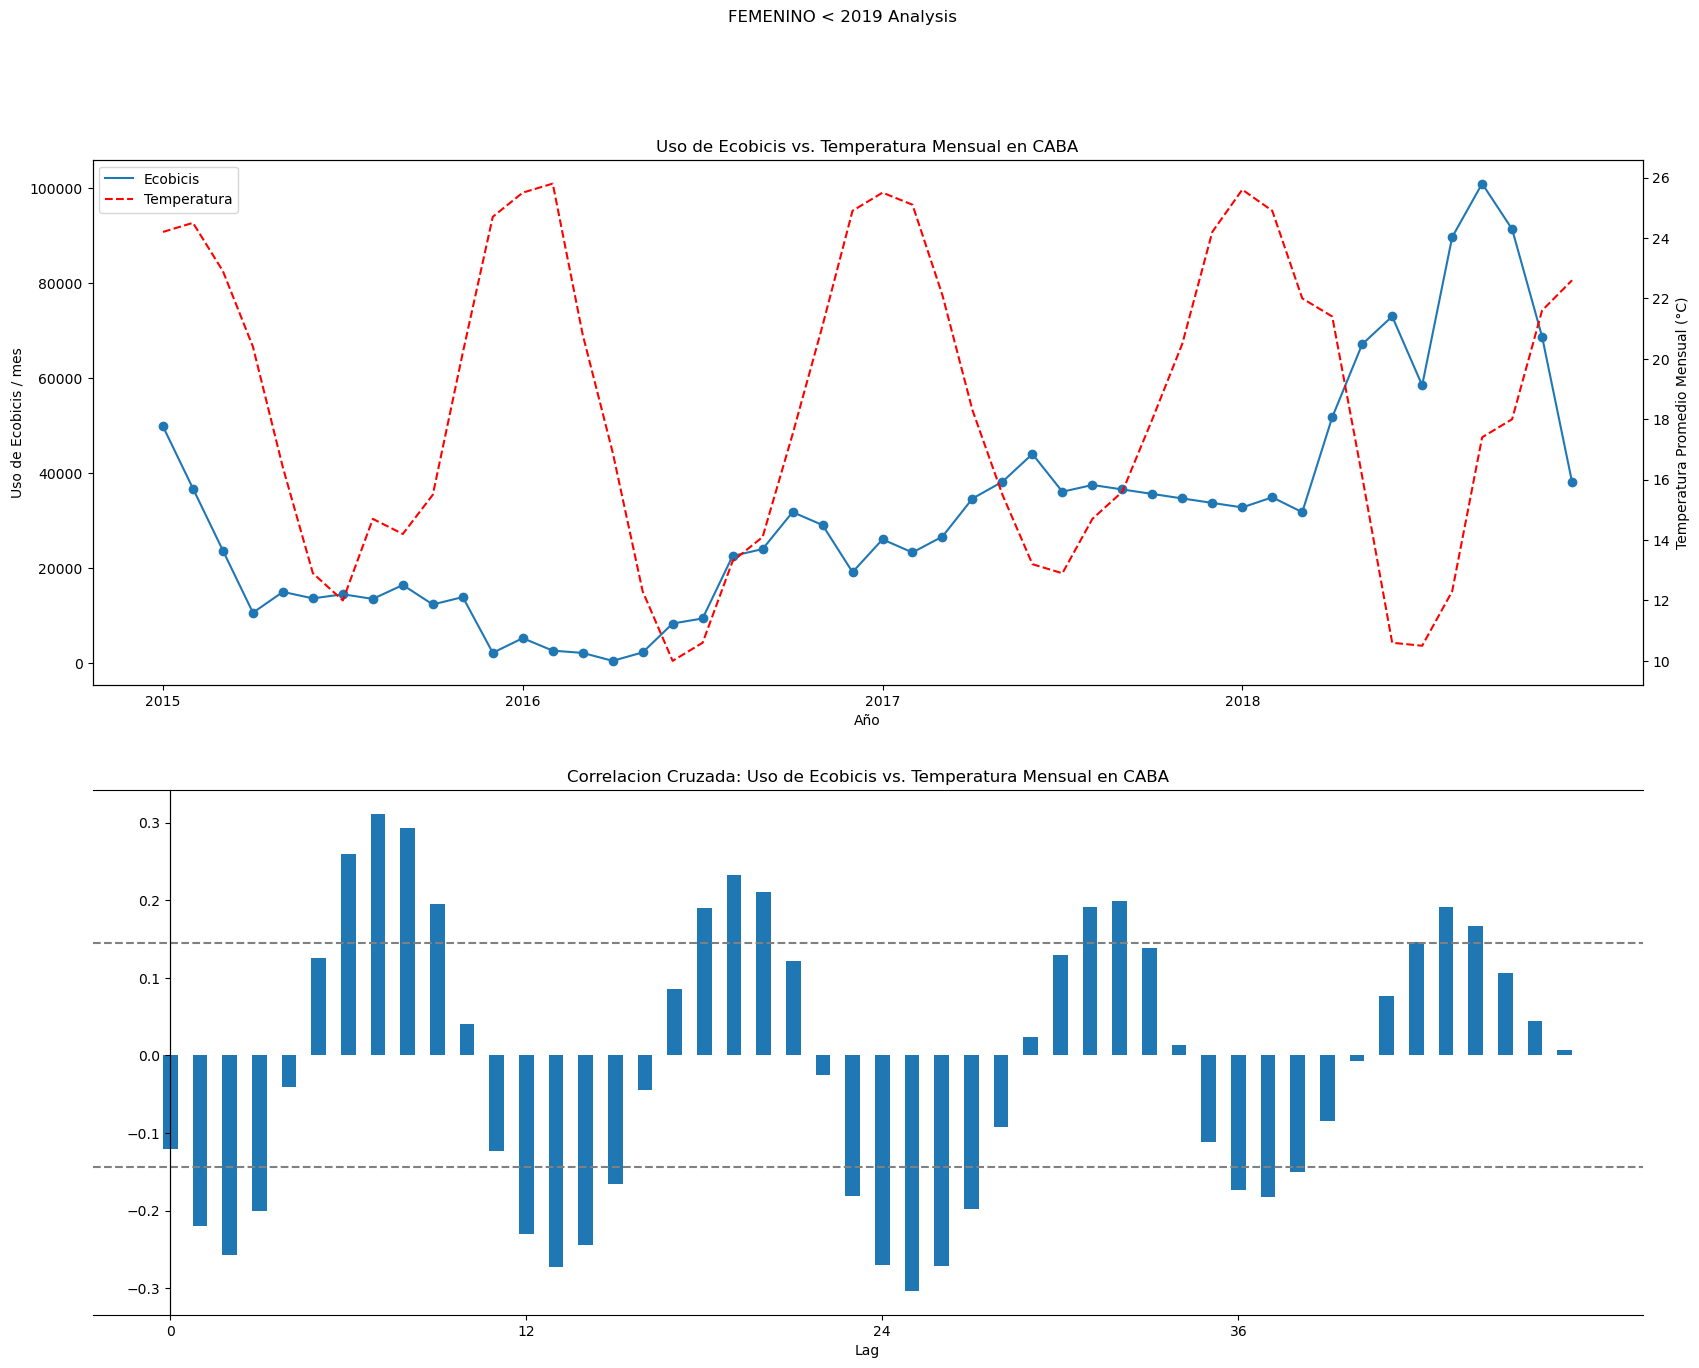

Coeficiente de Correlacion de Pearson: -0.12122195375759603


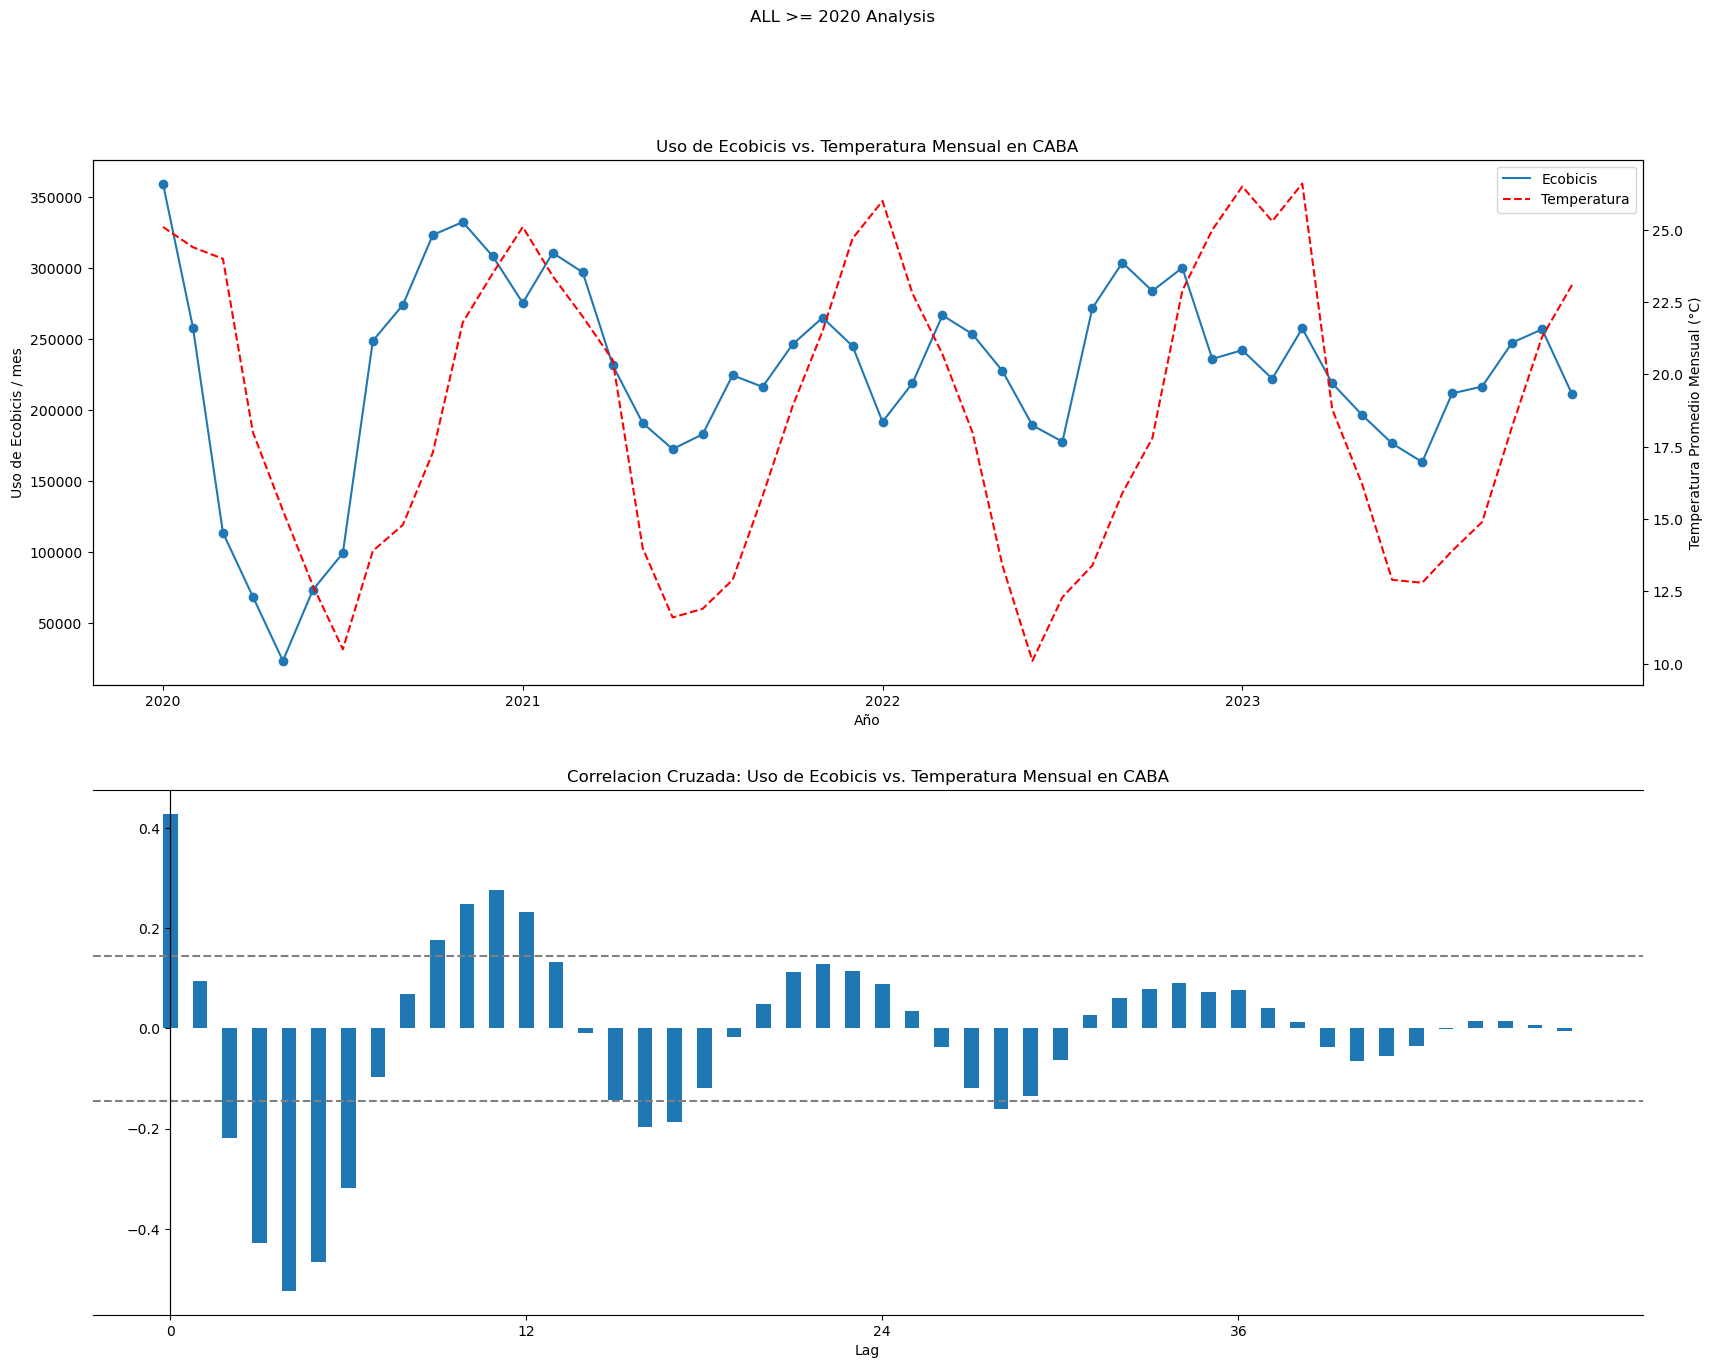

Coeficiente de Correlacion de Pearson: 0.42826329410159075


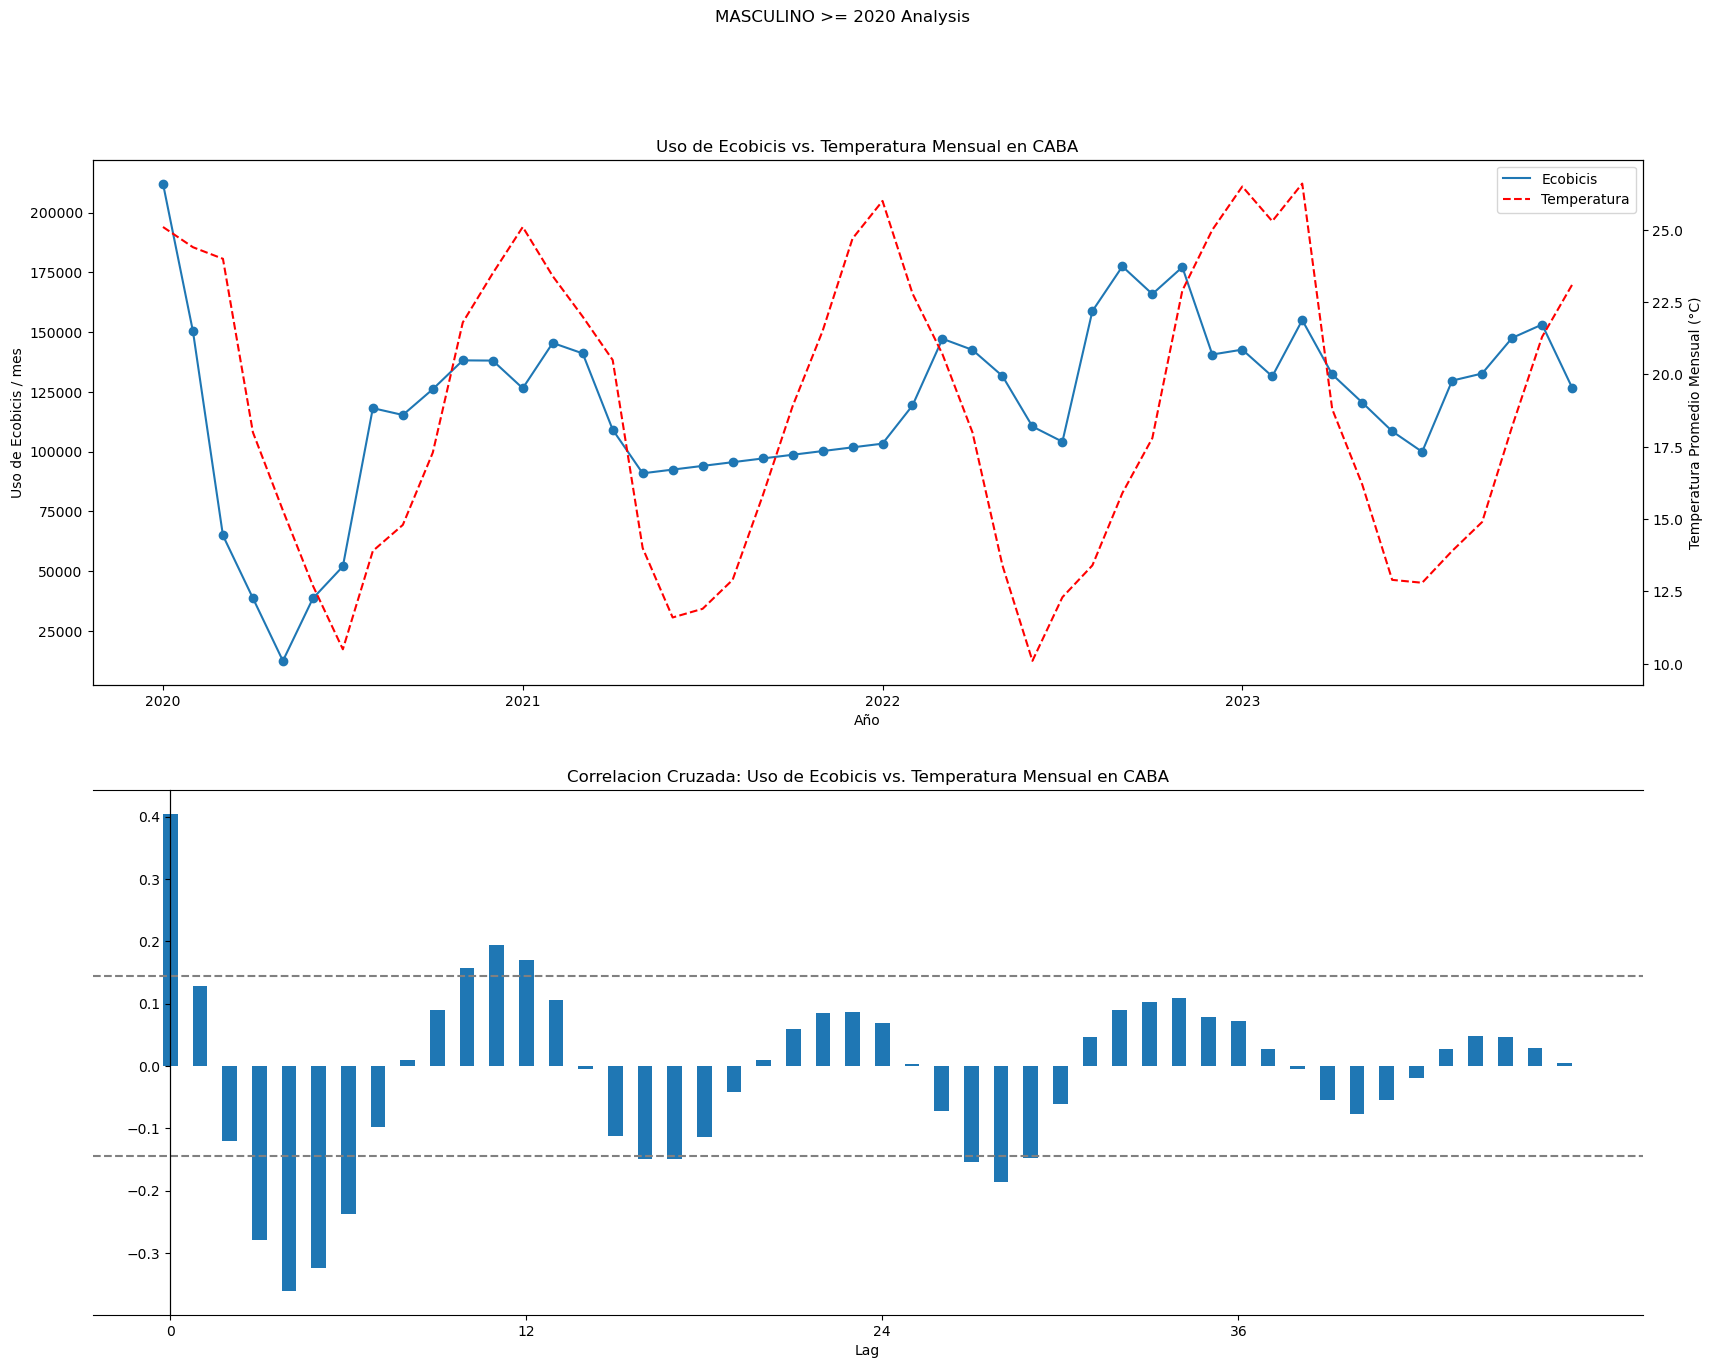

Coeficiente de Correlacion de Pearson: 0.40494800077012305


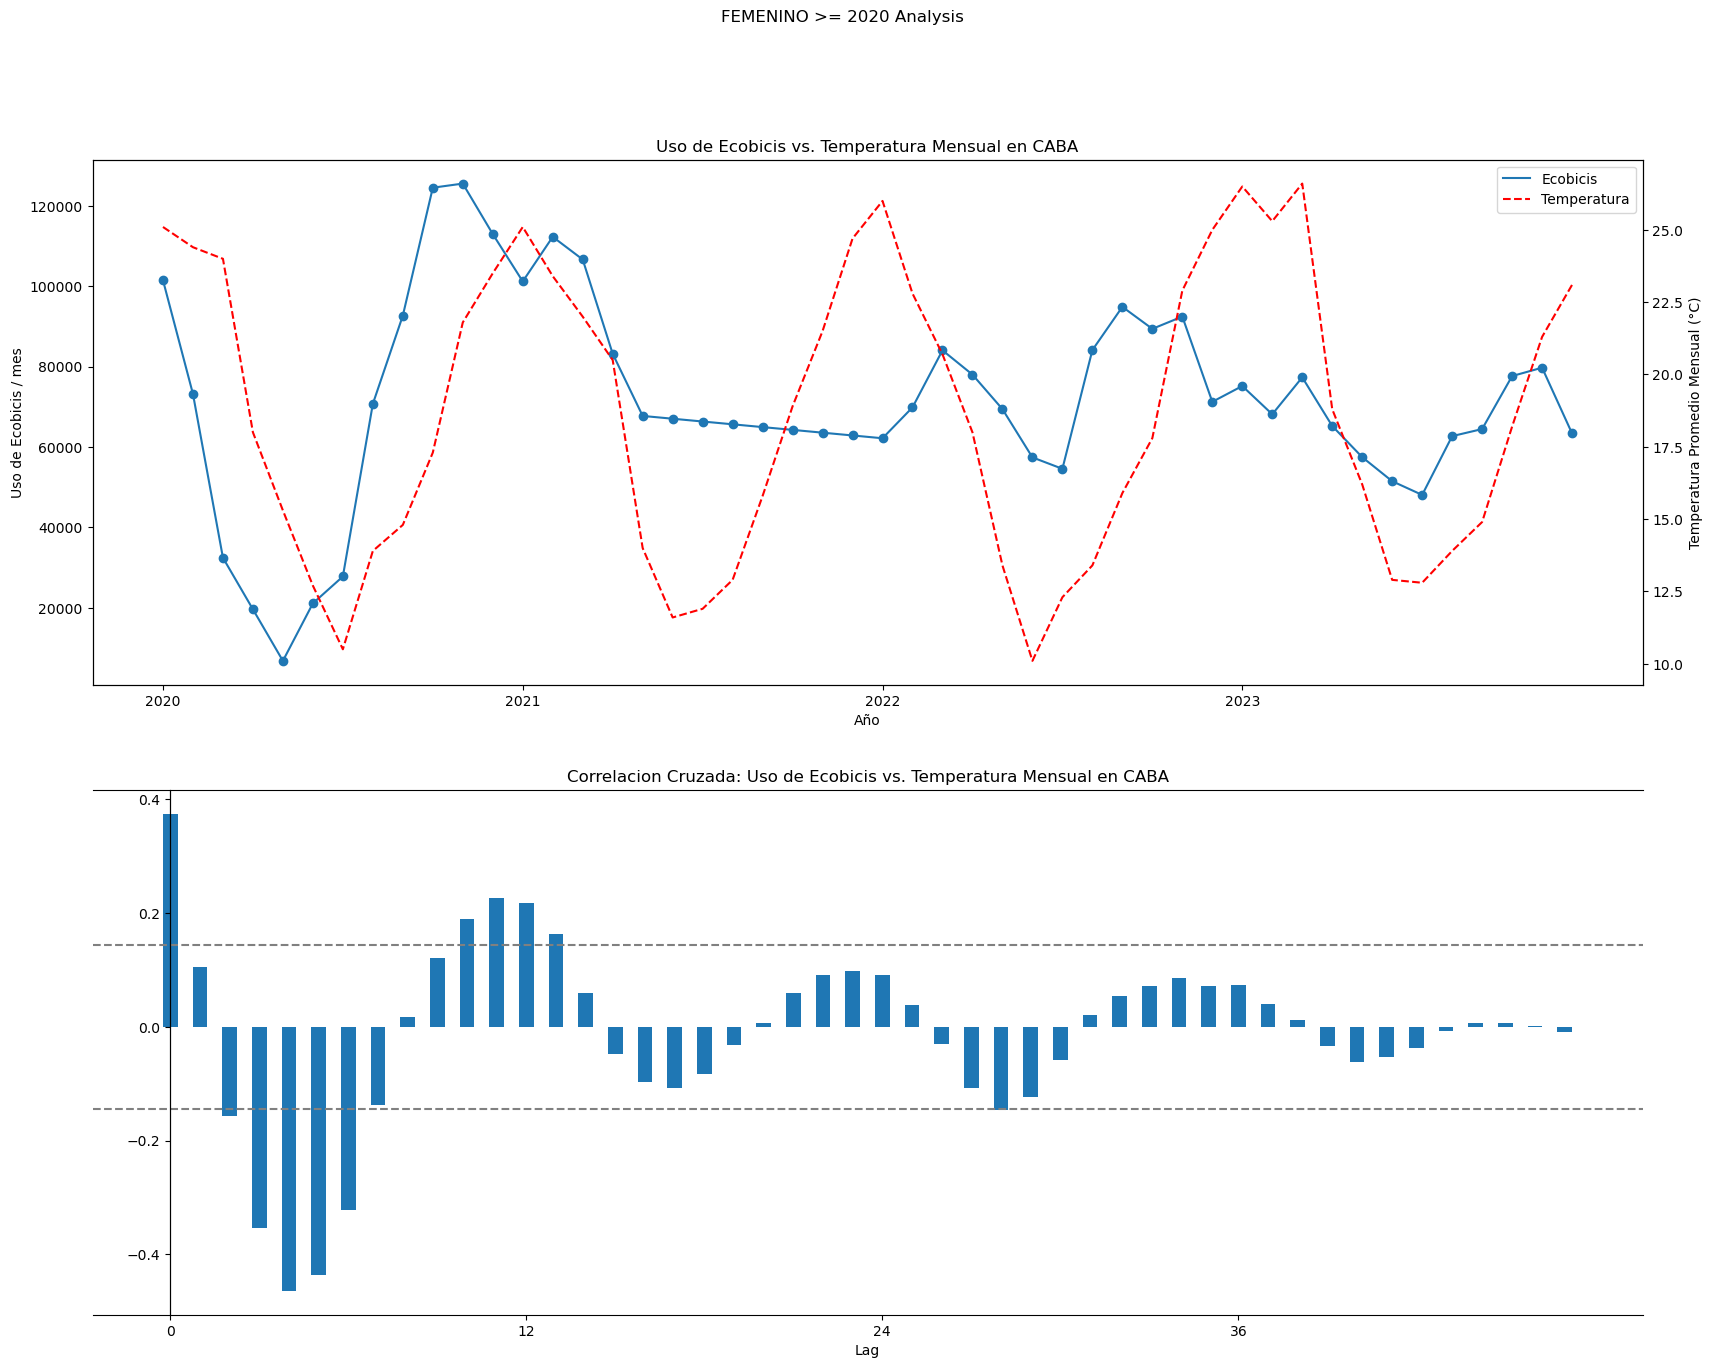

Coeficiente de Correlacion de Pearson: 0.3743217199160302


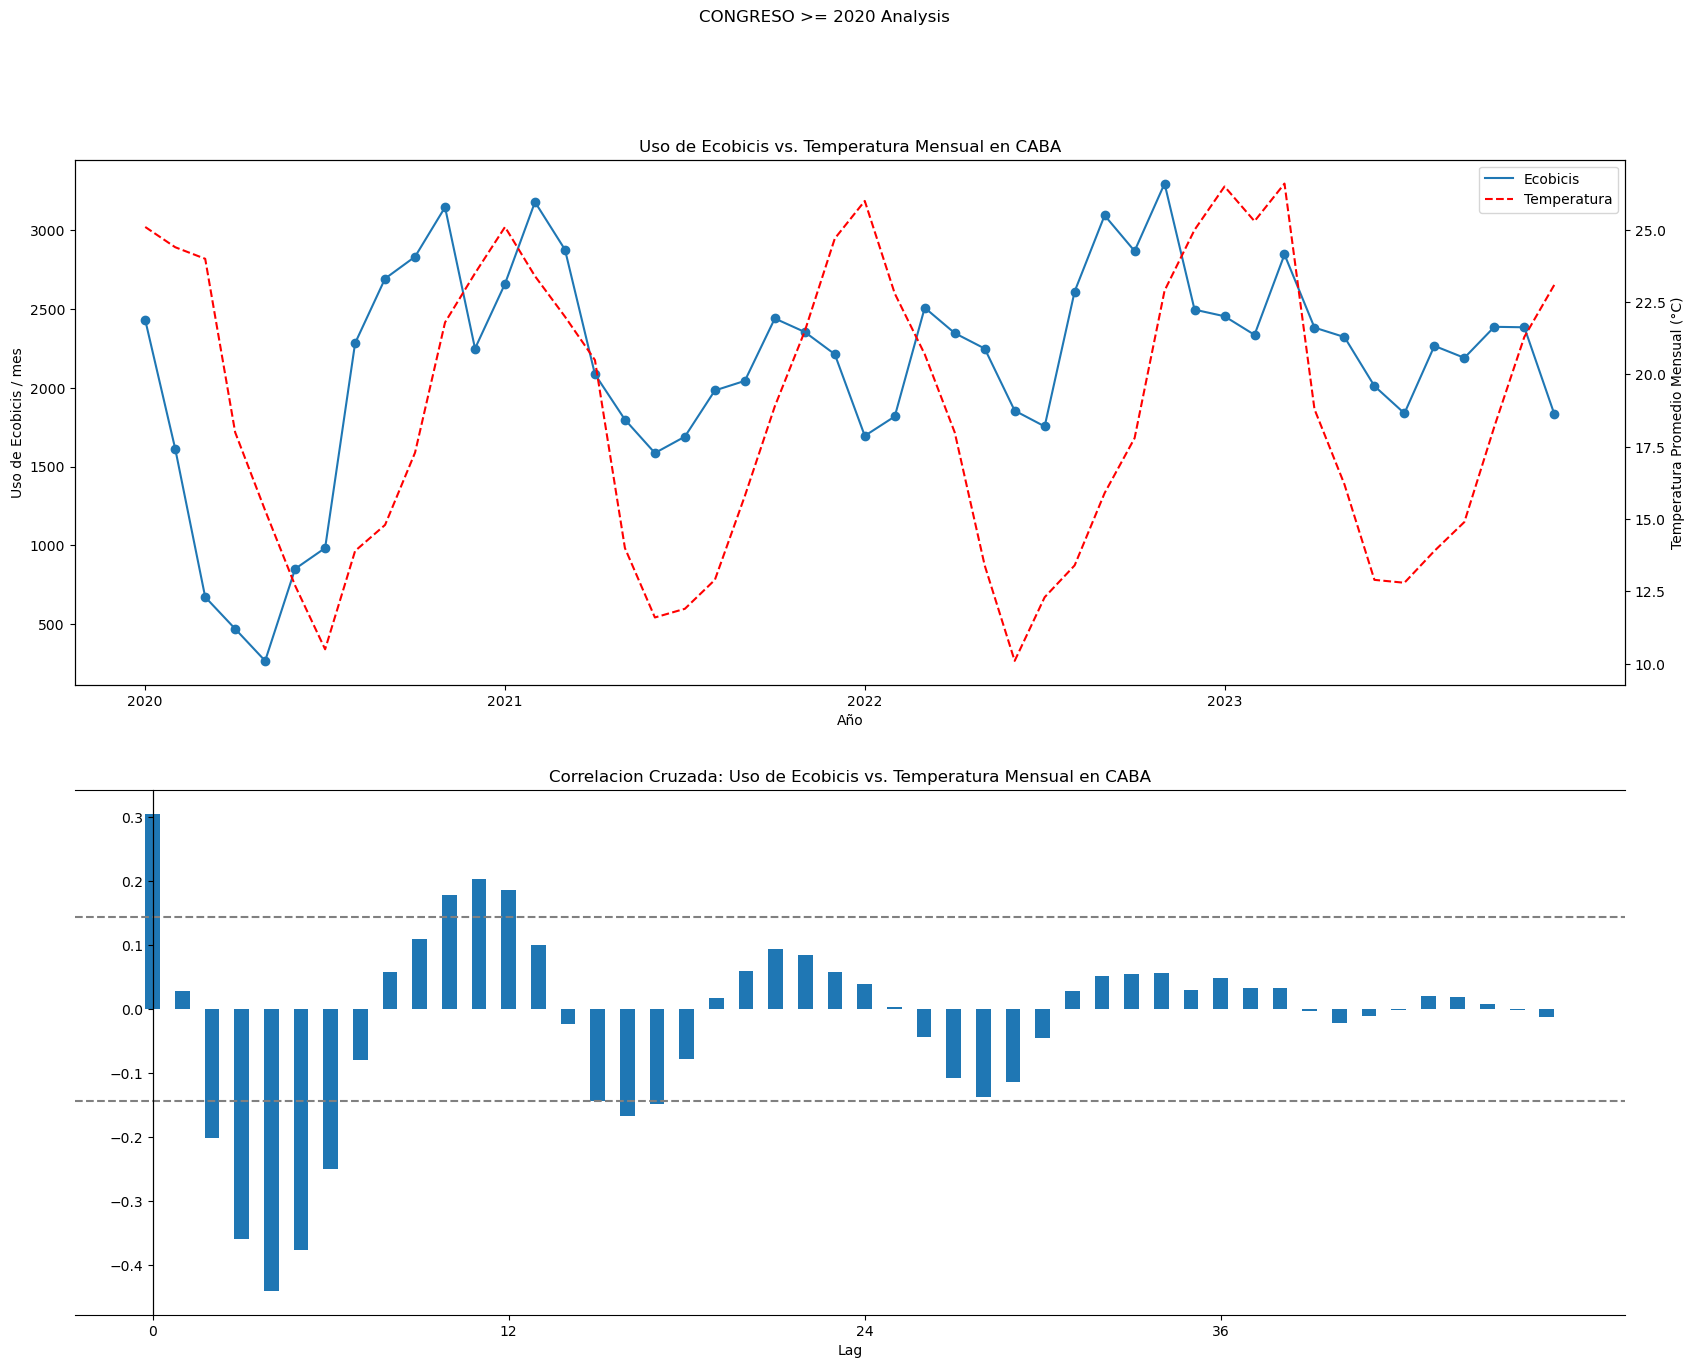

Coeficiente de Correlacion de Pearson: 0.3056886731225442


In [42]:
for name, df in analysis.items():
    run_analysis(df, f"{name} Analysis")

In [52]:
# origen_count = (
#     pd.DataFrame(
#         recorridos_data[recorridos_data["ANIO"] >= 2020]
#         .groupby(["ORIGEN"], as_index=False)
#         .size()
#     )
#     .rename(columns={"size": "RECORRIDOS"})
#     .sort_values(by="RECORRIDOS", ascending=False)
# )
# origen_count.head(3)

top3_origen = ["PACIFICO", "CONSTITUCIÓN", "PLAZA ITALIA"]

analysis = {}
for origen in top3_origen:
    target_data = group_data(
        recorridos_data[
            recorridos_data["ORIGEN"].str.upper().str.contains(origen)
            & (recorridos_data["ANIO"] > 2014)
        ]
    )
    analysis_data = prep_analysis_data(target_data)
    analysis[f"{origen} >= 2020"] = pd.DataFrame(
        analysis_data[analysis_data["ANIO"].between(2020, 2023)]
    ).reset_index(drop=True)

for name, df in analysis.items():
    print("Name:", name, ", Data Count", df.size)

Name: PACIFICO >= 2020 , Data Count 240
Name: CONSTITUCIÓN >= 2020 , Data Count 240
Name: PLAZA ITALIA >= 2020 , Data Count 240


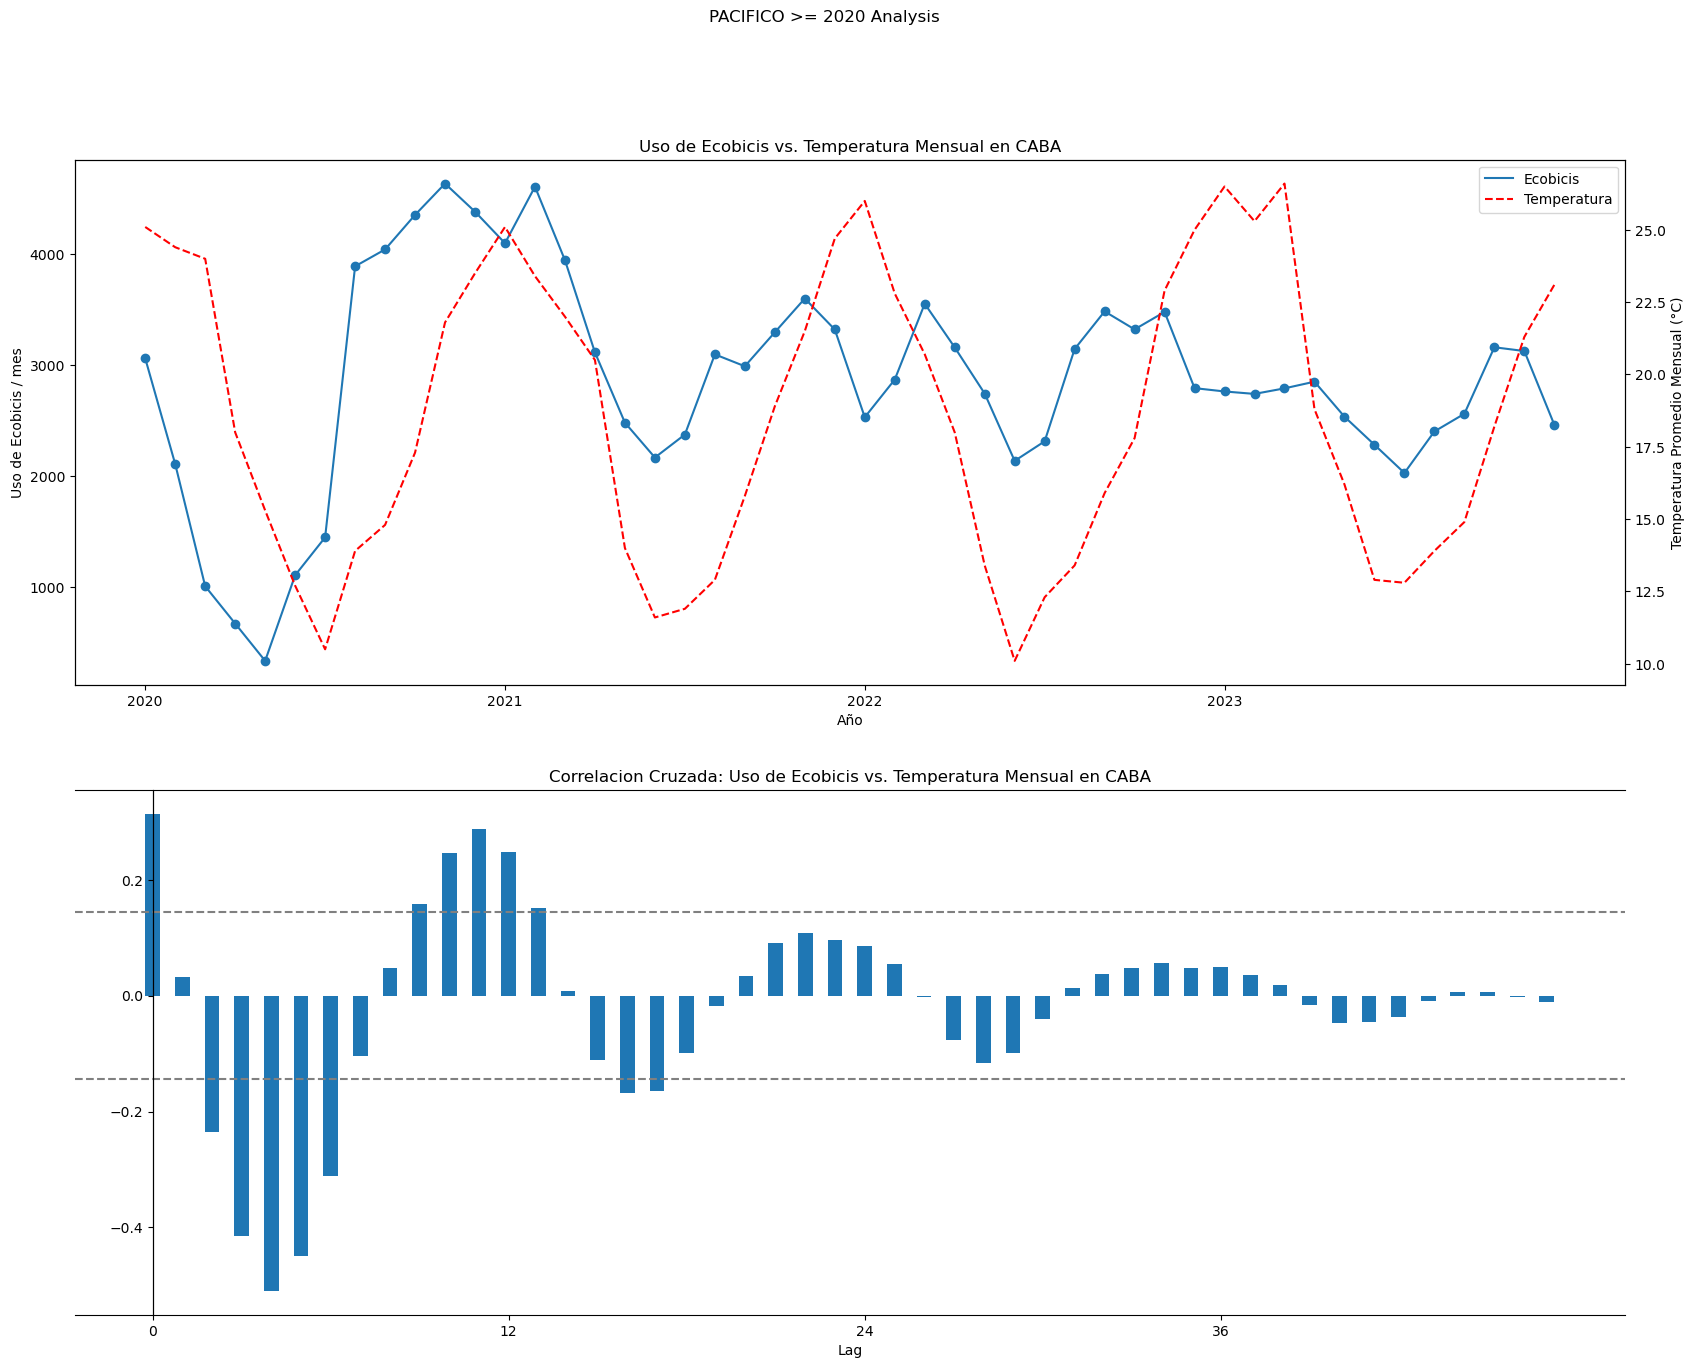

Coeficiente de Correlacion de Pearson: 0.31448208491688484


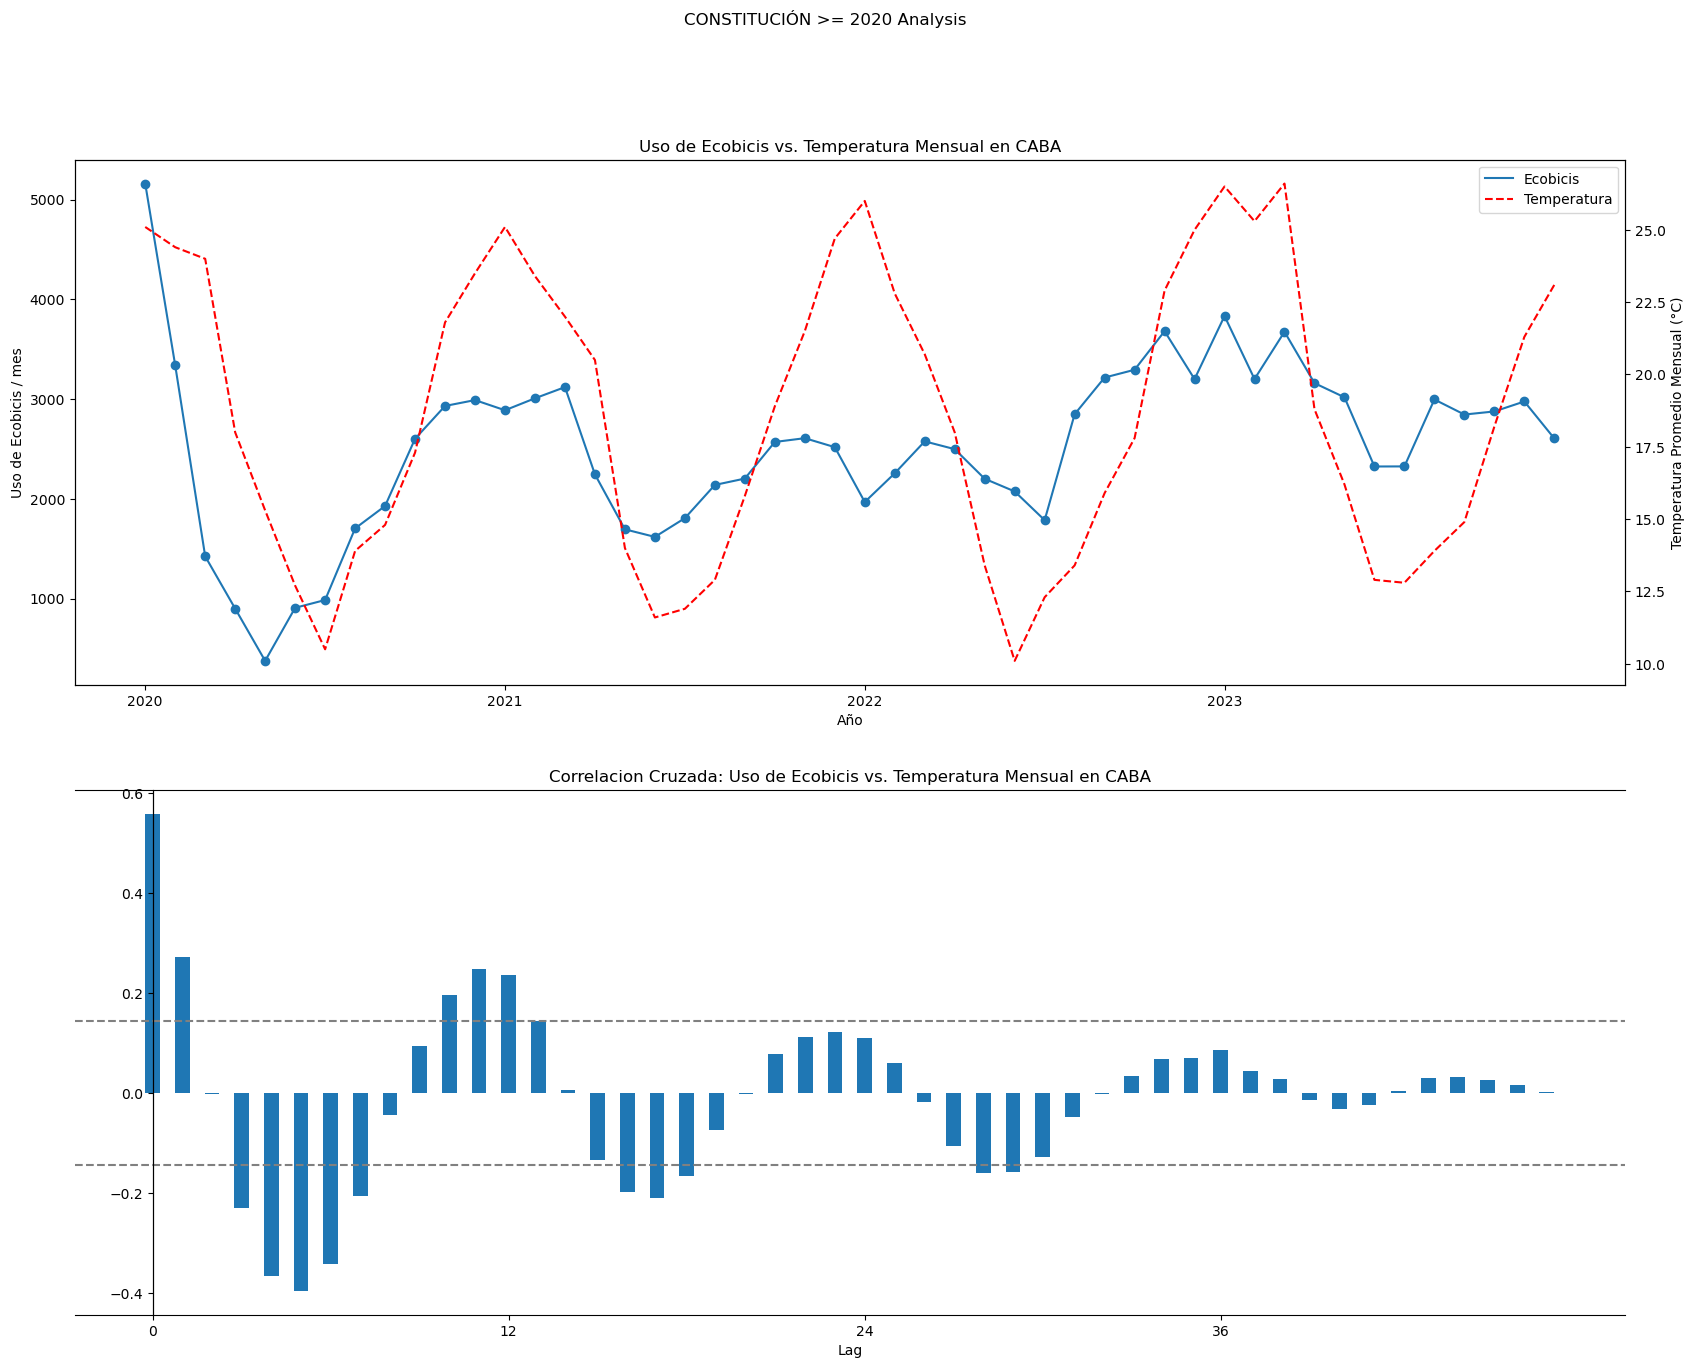

Coeficiente de Correlacion de Pearson: 0.5597469259639486


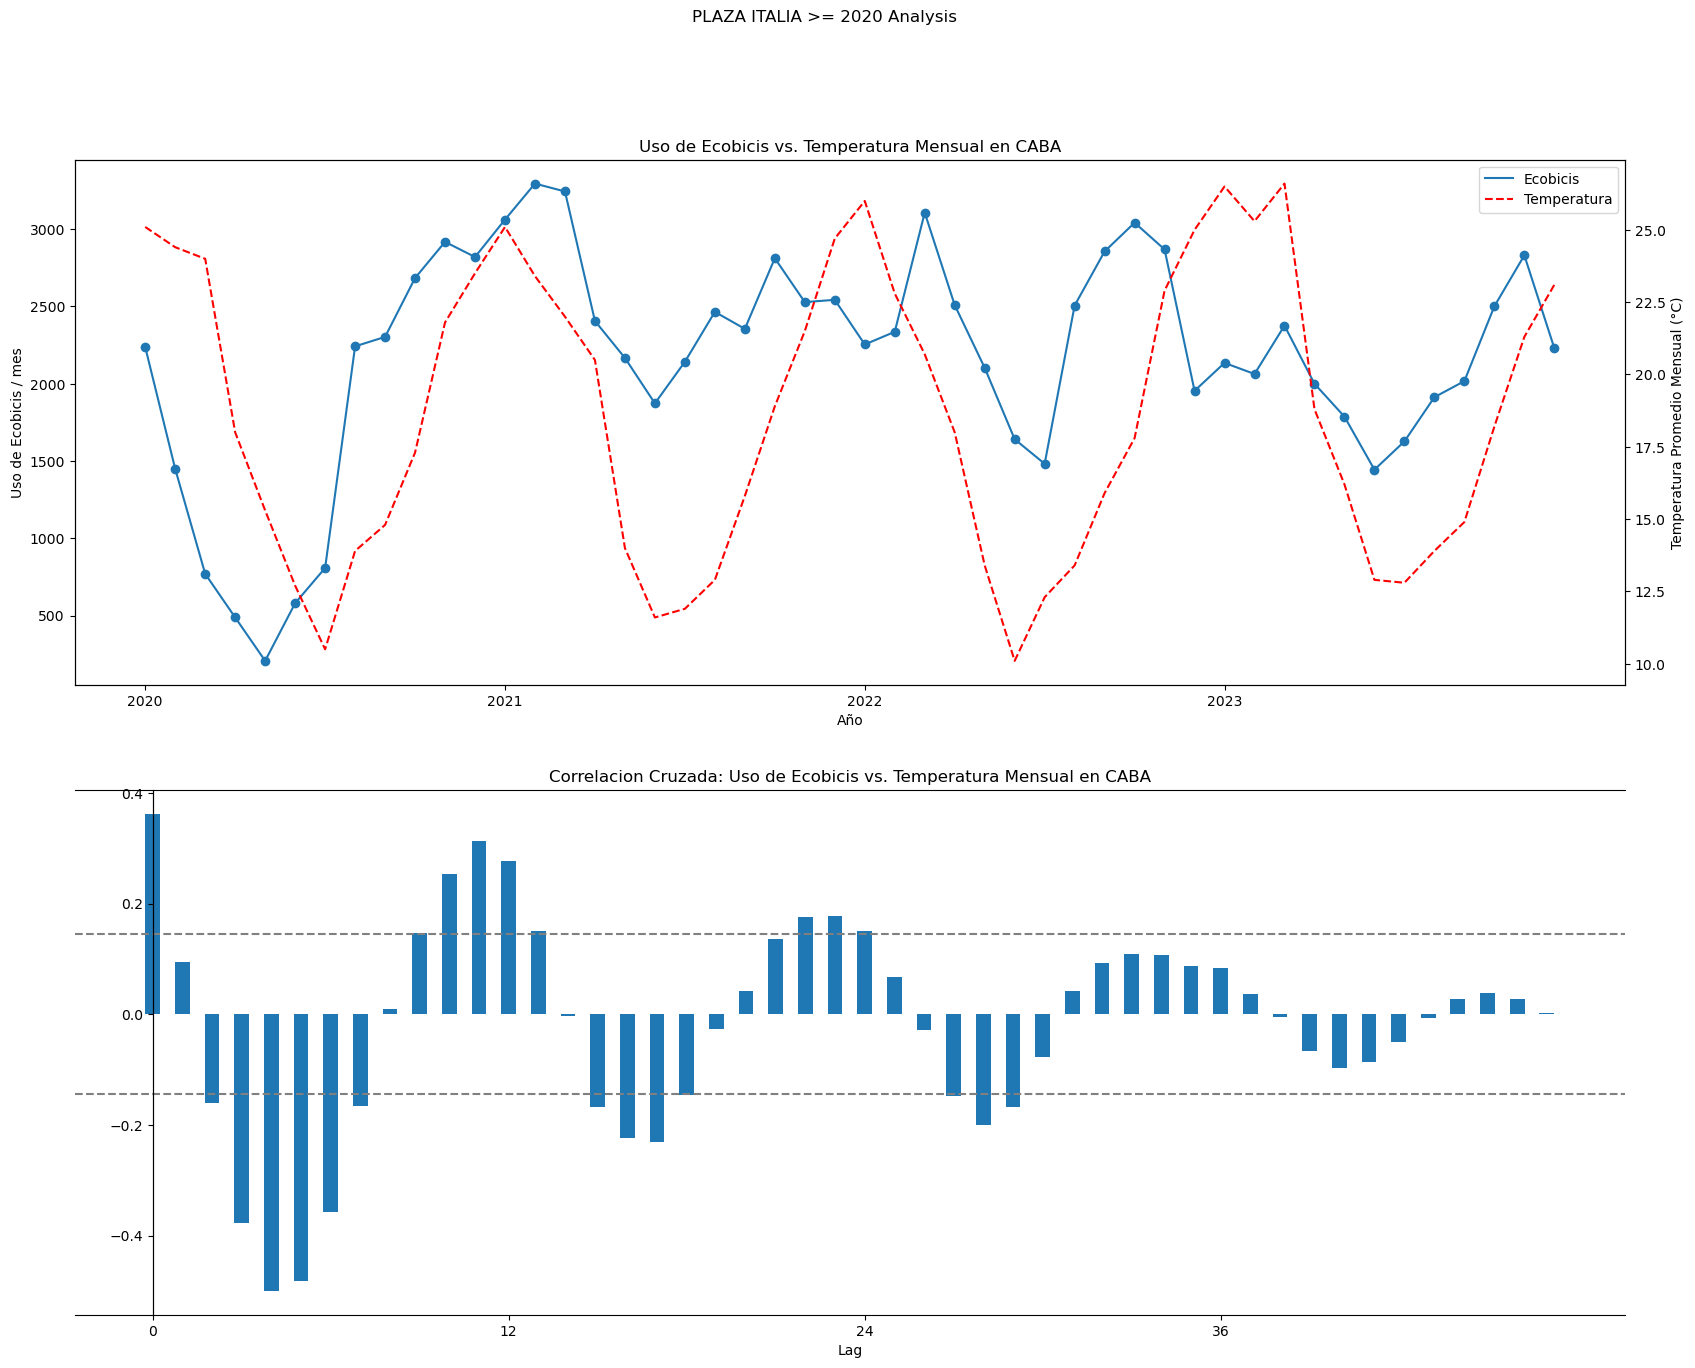

Coeficiente de Correlacion de Pearson: 0.36262007756703585


In [53]:
for name, df in analysis.items():
    run_analysis(df, f"{name} Analysis")